In [1]:
import os
import math
import shap
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Defining some useful variables

# Set the project folder
PRJ_FOLDER = '.'
# Set the folder the full dataset is located
DATA_FOLDER = os.path.join(PRJ_FOLDER, 'data')
# Set the name of the file that holds the full dataset
FULL_DATASET_NAME = 'full.csv'
# Set "No Audio" dataset
NO_AUDIO_DATASET_NAME = 'no_audio_corrected.csv'
# Set the name of the file that holds the angraphic information
LABELS_NAME = 'plasma_labels.csv'

TOP_K = 16

# Load the labels only once, in order to reuse them
LABELS = pd.read_csv(os.path.join(DATA_FOLDER, LABELS_NAME))

# SMOTE Upsampler
SMOTE = BorderlineSMOTE()


print(f'Folder where the entire project is located: {PRJ_FOLDER}')
print(f'Folder where the full dataset is saved: {DATA_FOLDER}')
print(f'Name of the full dataset: {FULL_DATASET_NAME}')
print(f'Name of the anagraphic dataset: {LABELS_NAME}')

Folder where the entire project is located: .
Folder where the full dataset is saved: .\data
Name of the full dataset: full.csv
Name of the anagraphic dataset: plasma_labels.csv


In [3]:
# Let's define a simple function that loads a single dataset

def load_raw_data(csv_path: str, feat_to_predict: str):
    # Load the entire csv file
    data = pd.read_csv(csv_path)

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', feat_to_predict]]
    lbls[feat_to_predict] = lbls[feat_to_predict].map(lambda x: np.nan if x==' ' else x)
    lbls = lbls.dropna()
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    temp[feat_to_predict] = temp[feat_to_predict].astype(int)
    # Extract only the ground truths
    labels = pd.DataFrame(temp[feat_to_predict], columns=[feat_to_predict])
    data = temp.drop(feat_to_predict, axis=1)
    data = data.set_index('id')
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)

    return data, labels

In [4]:
def print_feats(feats):
    cur, idx = [], 0
    for feat in feats:
        cur.append(str(feat))
        idx += 1
        if (idx % 5) == 0:
            print(', '.join(cur) + ',')
            cur = []
    if len(cur) > 0:
        print(', '.join(cur))

In [5]:
def plot_best_feat(feats, scores, yerr=None, title: str = '', dimensions=(10,8)):
    plt.rcParams["figure.figsize"] = dimensions

    feats, scores = list(reversed(feats)), list(reversed(scores))

    if yerr:
        plt.barh(feats, scores, yerr=yerr, capsize=6)
    else:
        plt.barh(feats, scores)
    plt.title(title)
    plt.xlabel('Score')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]

In [6]:
def plot_compounded(folds, title, dimensions=(10, 12)):
    plt.rcParams["figure.figsize"] = dimensions
    
    count = {}
    for feats, _ in folds:
        for feat in feats:
            if feat not in count:
                count[feat] = 0
            count[feat] += 1
    comp = sorted(list(count.items()), key=(lambda x: x[1]), reverse=True)
    feats, freqs = zip(*comp[:30])
    feats, freqs = list(reversed(list(feats))), list(reversed(list(freqs)))
    
    plt.barh(feats, freqs)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]


# ML Approach

In [7]:
def ml_analysis(feat_to_predict, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)

    X, y = load_raw_data(PATH, feat_to_predict)
    results = []
    for _ in range(1000):
        X_train, __, y_train, __ = train_test_split(X, y, test_size=0.2, stratify=y)
        X_train, y_train = SMOTE.fit_resample(X_train, y_train)
        
        sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        sel.fit(X_train, y_train)

        support = sel.get_support()
        selected_feat = X.columns[support].tolist()
        selected_importances = sel.estimator_.feature_importances_.ravel()
        
        final_sorted = sorted(list(zip(selected_feat, selected_importances)), key=(lambda x: x[1]), reverse=True)
        feats, importances = zip(*(final_sorted[:TOP_K]))
        results.append((feats, importances))

    return plot_compounded(results, feat_to_predict)


### No Audio

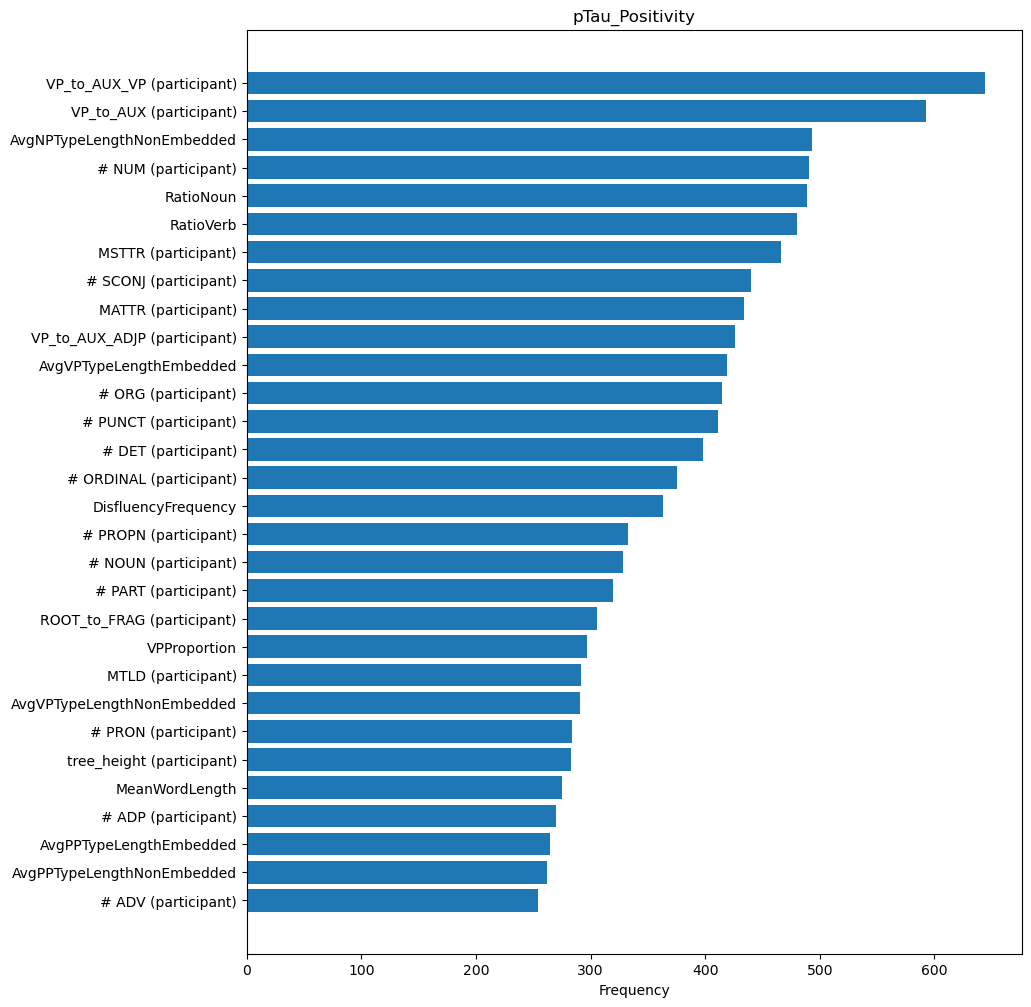

VP_to_AUX_VP (participant), VP_to_AUX (participant), AvgNPTypeLengthNonEmbedded, # NUM (participant), RatioNoun,
RatioVerb, MSTTR (participant), # SCONJ (participant), MATTR (participant), VP_to_AUX_ADJP (participant),
AvgVPTypeLengthEmbedded, # ORG (participant), # PUNCT (participant), # DET (participant), # ORDINAL (participant),
DisfluencyFrequency, # PROPN (participant), # NOUN (participant), # PART (participant), ROOT_to_FRAG (participant),
VPProportion, MTLD (participant), AvgVPTypeLengthNonEmbedded, # PRON (participant), tree_height (participant),
MeanWordLength, # ADP (participant), AvgPPTypeLengthEmbedded, AvgPPTypeLengthNonEmbedded, # ADV (participant),


In [8]:
TTAU_ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('pTau_Positivity', audio=False)

# Statistical Approach

In [9]:
def get_topK(X, y, cols, score_func, k=32):
    # Create object that will rank features based on the score function
    select = SelectKBest(score_func=score_func)
    top_ks = []
    top_scores = []
    # Obtain the scores for all the features
    scores = list(select.fit(X, y).scores_)
    # Associate each score to the feature that is related to
    n_scores = list(zip(scores, [i for i in range(len(scores))]))
    # Sort the scores from highest to lowest
    n_scores.sort(key=lambda x: x[0], reverse=True)
    # Retrieve scores and features indexes
    scores, pos = zip(*n_scores)
    # Save top-k scores and their feature names
    top_scores.append(list(scores[:k]))
    top_ks.append(list(cols[list(pos)[:k]]))

    return top_ks, top_scores

## F_Cassif

In [10]:
def f_info(feat_to_predict: str, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, feat_to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_numpy()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    # F Function
    f_top_ks, f_top_scores = get_topK(X, y, cols, f_classif)
    f_top_ks, f_top_scores = f_top_ks[0], f_top_scores[0]
    mapped = list(filter(lambda x: not math.isnan(x[1]), list(zip(f_top_ks, f_top_scores))))
    f_top_ks, f_top_scores = zip(*sorted(mapped, key=(lambda x: x[1]), reverse=True))
    return plot_best_feat(f_top_ks, f_top_scores, title=f'F_Function Scores ({feat_to_predict} - {"Full" if audio else "No Audio"})')

### No Audio

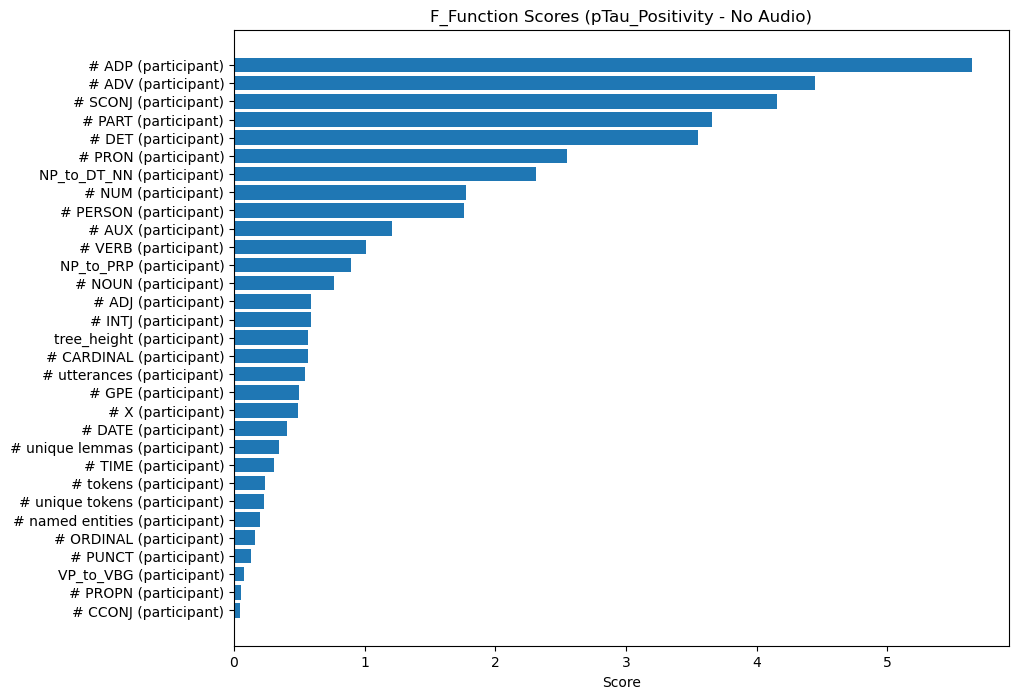

# ADP (participant), # ADV (participant), # SCONJ (participant), # PART (participant), # DET (participant),
# PRON (participant), NP_to_DT_NN (participant), # NUM (participant), # PERSON (participant), # AUX (participant),
# VERB (participant), NP_to_PRP (participant), # NOUN (participant), # ADJ (participant), # INTJ (participant),
tree_height (participant), # CARDINAL (participant), # utterances (participant), # GPE (participant), # X (participant),
# DATE (participant), # unique lemmas (participant), # TIME (participant), # tokens (participant), # unique tokens (participant),
# named entities (participant), # ORDINAL (participant), # PUNCT (participant), VP_to_VBG (participant), # PROPN (participant),
# CCONJ (participant)


In [11]:
TTAU_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('pTau_Positivity', audio=False)

## Mutual Information

In [12]:
def m_info(to_predict, runs=1000, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_list()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    importances = mutual_info_classif(X, y)
    feat_importances = pd.Series(importances, cols)
    feat_importances = feat_importances.nlargest(32).sort_values()
    for _ in range(runs):
        new_feat_importances = pd.Series(mutual_info_classif(X, y), cols)
        new_feat_importances = new_feat_importances.nlargest(32).sort_values()
        for col in new_feat_importances.index:
            if col not in feat_importances.index:
                feat_importances[col] = 0
            feat_importances[col] += new_feat_importances[col]
    feat_importances = feat_importances / runs
    feat_importances = feat_importances.nlargest(32).sort_values()
    feat_importances.plot(kind='barh')
    plt.title(f'Mutual Information ({to_predict} - {"Full" if audio else "No Audio"})')
    plt.show()
    print_feats(list(feat_importances.index)[::-1])
    return list(feat_importances.index[::-1])

### No Audio

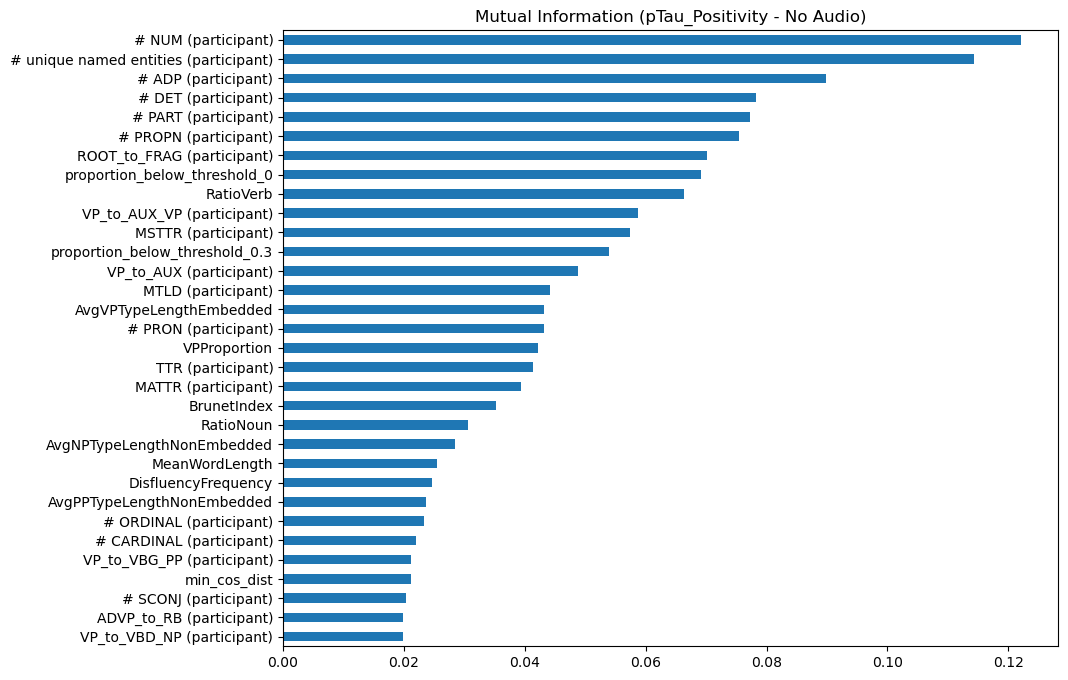

# NUM (participant), # unique named entities (participant), # ADP (participant), # DET (participant), # PART (participant),
# PROPN (participant), ROOT_to_FRAG (participant), proportion_below_threshold_0, RatioVerb, VP_to_AUX_VP (participant),
MSTTR (participant), proportion_below_threshold_0.3, VP_to_AUX (participant), MTLD (participant), AvgVPTypeLengthEmbedded,
# PRON (participant), VPProportion, TTR (participant), MATTR (participant), BrunetIndex,
RatioNoun, AvgNPTypeLengthNonEmbedded, MeanWordLength, DisfluencyFrequency, AvgPPTypeLengthNonEmbedded,
# ORDINAL (participant), # CARDINAL (participant), VP_to_VBG_PP (participant), min_cos_dist, # SCONJ (participant),
ADVP_to_RB (participant), VP_to_VBD_NP (participant)


In [13]:
TTAU_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('pTau_Positivity', audio=False)

# Best features combination

After some analysis, it's clear that the best (and more easily explainable) approach is based on using the No Audio data.</br>
Thus, we will try to understand which combnation of the previously highlighted features works best for each target label.

In [14]:
PATH = os.path.join(DATA_FOLDER, NO_AUDIO_DATASET_NAME)
STEPS = [2, 4, 8, 16]

def check_top_features(X, y, feats, steps=STEPS):
    len_feats = len(feats)
    mean_accs, mean_f1s = [], []
    stdev_accs, stdev_f1s = [], []
    for _step in steps:
        step = min(_step, len_feats)
        print(f'\nChecking top {step} features')
        
        X_current = X[feats[:step]]
        accs, f1s = [], []
        for _ in tqdm(range(1000)):
            X_train, X_test, y_train, y_test = train_test_split(X_current, y, test_size=0.2, stratify=y)
            X_train, y_train = SMOTE.fit_resample(X_train, y_train)

            model = RandomForestClassifier(n_estimators=200)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accs.append(accuracy_score(y_test['pTau_Positivity'], y_pred))
            f1s.append(f1_score(y_test['pTau_Positivity'], y_pred))

        mean_accs.append(np.mean(accs)), mean_f1s.append(np.mean(f1s))
        stdev_accs.append(np.std(accs)), stdev_f1s.append(np.std(f1s))

        if step != _step:
            break

    return (mean_accs, stdev_accs), (mean_f1s, stdev_f1s)


In [15]:
def plot_acc_and_f1(accs, f1s, feats, _steps=STEPS):
    steps = _steps[:]
    if len(feats) < _steps[-1]:
        steps = _steps[:len(accs[0])]
        steps[-1] = min(steps[-1], len(feats))
    
    x_axis = list(range(len(steps)))[:len(accs[0])]
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.title('Average Accuracy')
    plt.plot(x_axis, accs[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.subplot(122)
    plt.title('Average F1 Score')
    plt.plot(x_axis, f1s[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.show()

    for idx, step in enumerate(steps):
        print(f'**********   Top {step}   **********')
        print(f'Accuracy: {accs[0][idx]} +- {accs[1][idx]}')
        print(f'F1 Score: {f1s[0][idx]} +- {f1s[1][idx]}\n')

In [16]:
# Data Loading

X_ttau, y_ttau = load_raw_data(PATH, 'pTau_Positivity')

### pTau_Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:18<00:00,  5.03it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:23<00:00,  4.91it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:46<00:00,  3.49it/s]


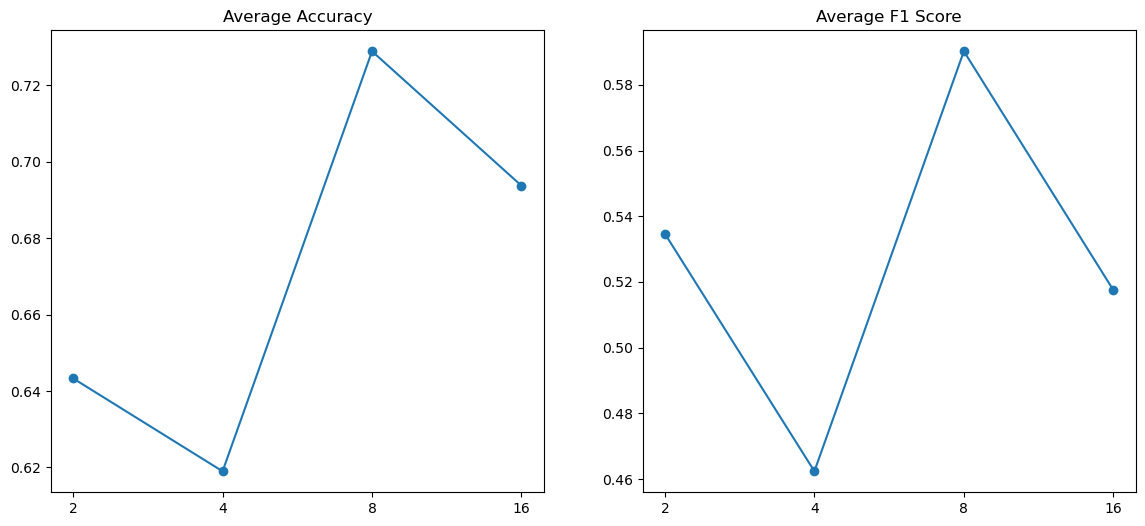

**********   Top 2   **********
Accuracy: 0.6433125 +- 0.11006303236668522
F1 Score: 0.5346448956444313 +- 0.15901063558934533

**********   Top 4   **********
Accuracy: 0.619 +- 0.10493271653778911
F1 Score: 0.4623687371108424 +- 0.16772394445933522

**********   Top 8   **********
Accuracy: 0.7289375 +- 0.09865167177372108
F1 Score: 0.5902117389146799 +- 0.16344321735692155

**********   Top 16   **********
Accuracy: 0.69375 +- 0.10285001215362108
F1 Score: 0.5175457292707292 +- 0.18501581562936684



In [17]:
ttau_ml_feats = TTAU_ML_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_ml_accs, ttau_ml_f1s = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_acc_and_f1(ttau_ml_accs, ttau_ml_f1s, ttau_ml_feats)

In [38]:
ttau_ml_feats[:8]

['VP_to_AUX_VP (participant)',
 'VP_to_AUX (participant)',
 'AvgNPTypeLengthNonEmbedded',
 '# NUM (participant)',
 'RatioNoun',
 'RatioVerb',
 'MSTTR (participant)',
 '# SCONJ (participant)']

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:18<00:00,  5.03it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:23<00:00,  4.91it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:43<00:00,  3.53it/s]


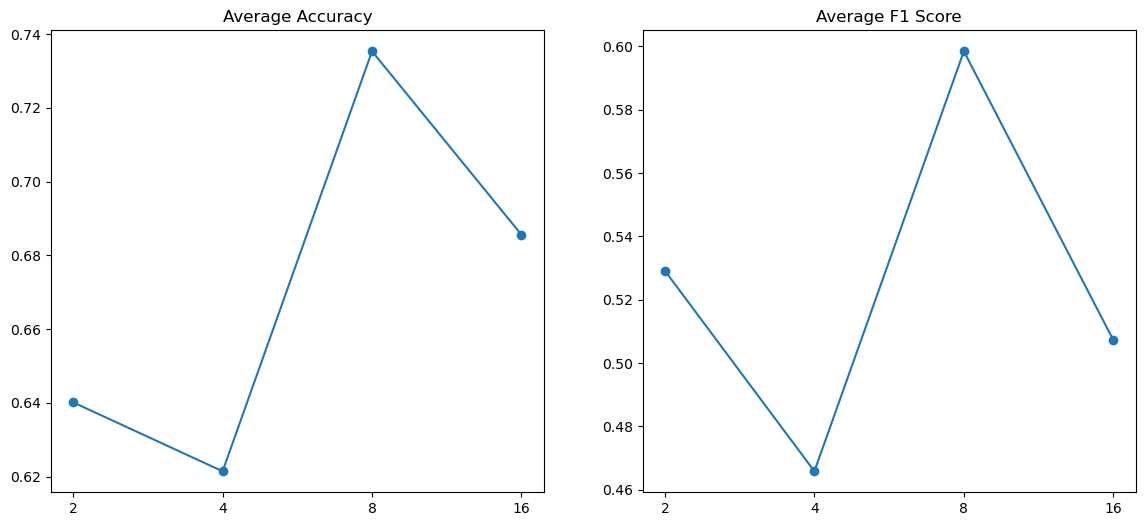

**********   Top 2   **********
Accuracy: 0.640125 +- 0.1076640463432431
F1 Score: 0.5291243783478303 +- 0.15472492148244846

**********   Top 4   **********
Accuracy: 0.6214375 +- 0.10200626129679492
F1 Score: 0.46586079891041193 +- 0.16394786813865334

**********   Top 8   **********
Accuracy: 0.7353125 +- 0.09925061004220578
F1 Score: 0.5984208887517711 +- 0.17142387296667017

**********   Top 16   **********
Accuracy: 0.6855625 +- 0.10300255988930566
F1 Score: 0.5072802894817601 +- 0.18140333685758064



In [18]:
ttau_f_classif_feats = TTAU_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_f_classif_accs, ttau_f_classif_f1s = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_acc_and_f1(ttau_f_classif_accs, ttau_f_classif_f1s, ttau_f_classif_feats)

In [39]:
ttau_f_classif_feats[:8]

['# ADP (participant)',
 '# ADV (participant)',
 '# SCONJ (participant)',
 '# PART (participant)',
 '# DET (participant)',
 '# PRON (participant)',
 'NP_to_DT_NN (participant)',
 '# NUM (participant)']

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:25<00:00,  4.88it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:25<00:00,  4.87it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:43<00:00,  3.53it/s]


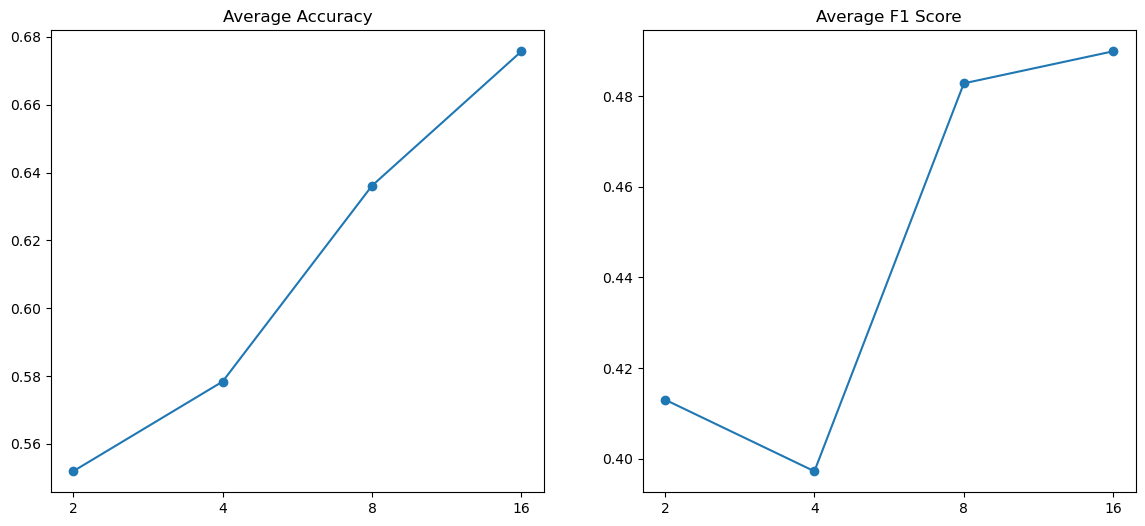

**********   Top 2   **********
Accuracy: 0.5519375 +- 0.10710025603960992
F1 Score: 0.4130650391318348 +- 0.15329272740421754

**********   Top 4   **********
Accuracy: 0.578375 +- 0.11189915940256209
F1 Score: 0.39727150512885806 +- 0.17237994833144815

**********   Top 8   **********
Accuracy: 0.636125 +- 0.10687894729552681
F1 Score: 0.482782942384413 +- 0.16775916937694663

**********   Top 16   **********
Accuracy: 0.67575 +- 0.10167841462178687
F1 Score: 0.48985097680097683 +- 0.17786587759186356



In [19]:
ttau_mutual_info_feats = TTAU_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_mutual_info_accs, ttau_mutual_info_f1s = check_top_features(X_ttau, y_ttau, ttau_mutual_info_feats)
plot_acc_and_f1(ttau_mutual_info_accs, ttau_mutual_info_f1s, ttau_mutual_info_feats)

In [20]:
ttau_mix_features = []
a, b = ttau_ml_feats[:8], ttau_f_classif_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in ttau_mix_features:
            ttau_mix_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in ttau_mix_features:
            ttau_mix_features.append(b[idx])

ttau_mix_accs, ttau_mix_f1s = check_top_features(X_ttau, y_ttau, ttau_mix_features, [2,4,8,16])


Checking top 2 features


100%|██████████| 1000/1000 [03:22<00:00,  4.95it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:29<00:00,  4.78it/s]



Checking top 14 features


100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]


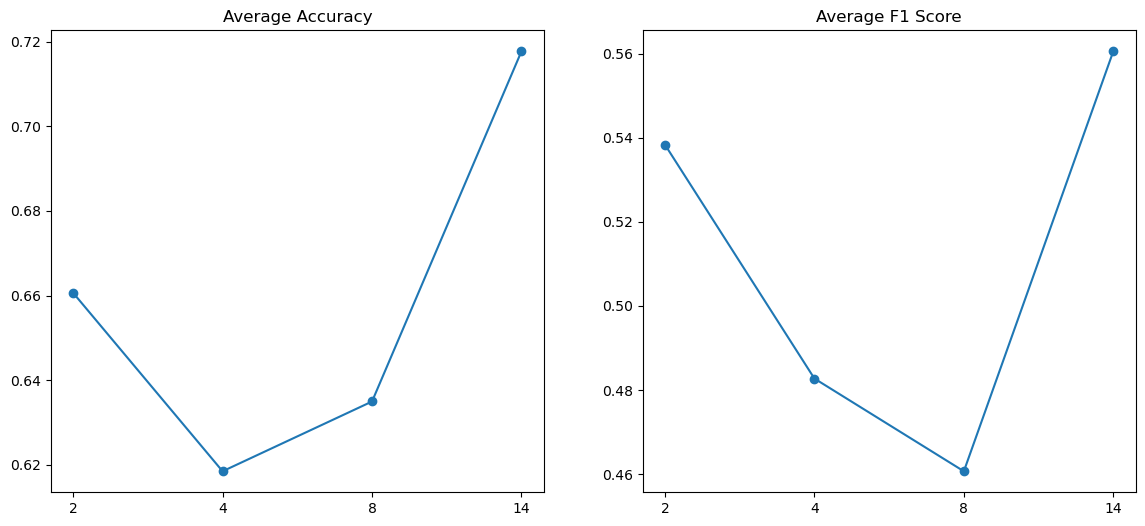

**********   Top 2   **********
Accuracy: 0.660625 +- 0.11396785456873354
F1 Score: 0.5383343039313627 +- 0.16106718376221538

**********   Top 4   **********
Accuracy: 0.6184375 +- 0.10330429489498488
F1 Score: 0.4827334425120803 +- 0.1552140275403721

**********   Top 8   **********
Accuracy: 0.6349375 +- 0.10424053838958239
F1 Score: 0.4606820695644225 +- 0.17222492410927917

**********   Top 14   **********
Accuracy: 0.71775 +- 0.10322427040187786
F1 Score: 0.560547027972028 +- 0.1781482475412024



In [21]:
plot_acc_and_f1(ttau_mix_accs, ttau_mix_f1s, ttau_mix_features)

### pTau_Positivity final results

For pTau we see that our possible best case scenario is obtained using either the `top 8 features` from the `ML approach` or the `top 8 features` from `F classif`.</br>

|             | `Accuracy`       | `F1 Score`       |
|-------------|------------------|------------------|
| `ML`        | 0.7289 +- 0.0987 | 0.5902 +- 0.1634 |
| `F classif` | 0.7353 +- 0.0993 | 0.5984 +- 0.1714 |

</br>

| `ML Features`               | `F_classif Features`      |
|-----------------------------|---------------------------|
| VP_to_AUX_VP (participant)  | # ADP (participant)       |
| VP_to_AUX (participant)     | # ADV (participant)       |
| AvgNPTypeLengthNonEmbedded  | # SCONJ (participant)     |
| # NUM (participant)         | # PART (participant)      |
| RatioNoun                   | # DET (participant)       |
| RatioVerb                   | # PRON (participant)      |
| MSTTR (participant)         | NP_to_DT_NN (participant) |
| # SCONJ (participant)       | # NUM (participant)       |

# Explainability

Our analysis yielded good results, but in order to strengthen our confidence in our work we need to explain our results.</br>
In particular, we are going to use the SHAP values in order to understand how the top features influence our predictions, and we'll compute the correlation between different feature groups and the target labels.

In [51]:
def load_exp(selected_feats, target, typ=int):
    # Load the entire csv file
    data = pd.read_csv('data/no_audio_corrected.csv')

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', target]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = temp[['id', target]].set_index('id').astype(typ)
    data = temp.drop(target, axis=1)
    data = data.set_index('id')
    # Keep just the selected features
    data = data[selected_feats]
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)
    data.columns = list(map(lambda x: x.replace(' (participant)', ''), data.columns.to_list()))
    data[target] = labels
    return data.reset_index()

In [87]:
import seaborn as sns

TTAU_EXP_FEATS_ML = [
    'VP_to_AUX_VP (participant)',
    'VP_to_AUX (participant)',
    'AvgNPTypeLengthNonEmbedded',
    '# NUM (participant)',
    'RatioNoun',
    'RatioVerb',
    'MSTTR (participant)',
    '# SCONJ (participant)'
]

TTAU_EXP_FEATS_F_CLASS = [
    '# ADP (participant)',
    '# ADV (participant)',
    '# SCONJ (participant)',
    '# PART (participant)',
    '# DET (participant)',
    '# PRON (participant)',
    'NP_to_DT_NN (participant)',
    '# NUM (participant)'
]

TARGETS = ['ML Approach', 'F_classif Approach']

## Variable Correlation

In [88]:
from scipy.stats.stats import pearsonr, spearmanr

def get_correlation(targets, corr_func, typ=int, special=None, filt= None, encoding=None):
    series, annots = [], []
    for idx, (feats, target, name) in enumerate(zip([TTAU_EXP_FEATS_ML, TTAU_EXP_FEATS_F_CLASS], ['pTau_Positivity', 'pTau_Positivity'], targets)):
        corr_df = load_exp(feats, target, typ).drop('id', axis=1)
        # If any filter is present, use it before everything
        if filt:
            corr_df = filt(corr_df)
        corr_target = corr_df[target]
        corr_df = corr_df.drop(target, axis=1)
        # Encode target variable if needed
        if encoding:
            corr_target = corr_target.apply(encoding)
        corr_target.rename(name)

        corr_coeffs, p_vals = [], []
        for col in corr_df.columns:
            corr = corr_func(corr_df[col], corr_target)
            corr_coeffs.append(round(corr[0], 2))
            p_vals.append(round(corr[1], 2))

        fixed = corr_df.columns.to_list()
        for _idx in range(len(fixed)):
            if fixed[_idx] == 'AvgVPTypeLengthEmbedded':
                fixed[_idx] = 'AvgVPType\nLengthEmbedded'
            if fixed[_idx] == 'AvgNPTypeLengthNonEmbedded':
                fixed[_idx] = 'AvgNPType\nLengthNon\nEmbedded'
            if fixed[_idx] == 'proportion_below_threshold_0.5':
                fixed[_idx] = 'proportion_below\nthreshold_0.5'
        corr_df.columns = fixed

        zipped = list(zip(corr_coeffs, p_vals, corr_df.columns.to_list()))
        corr_coeffs, p_vals, indx = zip(*sorted(zipped, key=lambda x: x[0], reverse=True))
        series.append(pd.DataFrame(corr_coeffs, index=indx, columns=[name]))
        annots.append(pd.DataFrame([f'{x}\n(p-val {y})' for x, y in zip(corr_coeffs, p_vals)], index=indx, columns=[name]))
    return series, annots

In [89]:
def plot_correlation(series, annots, title, order=[0,1,2]):
    fig, axs = plt.subplots(ncols=2, figsize=(8,8))
    fig.suptitle(title, size=16)
    sns.heatmap(series[0], annot=annots[0], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[0]], fmt = '')
    sns.heatmap(series[1], annot=annots[1], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[1]], fmt = '')
    plt.yticks(rotation=0) 
    plt.subplots_adjust(wspace=1, top=0.92)
    plt.show()

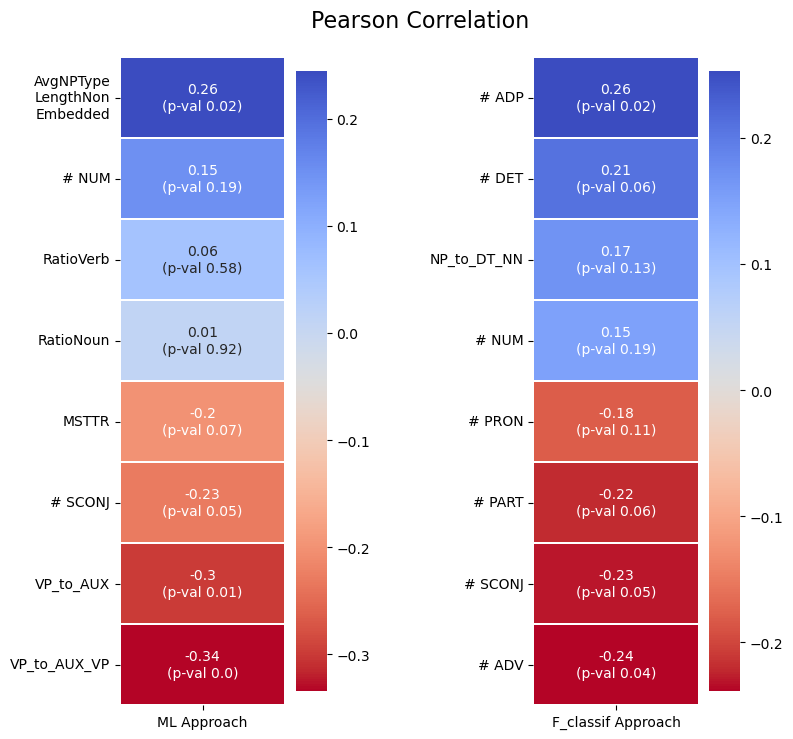

In [90]:
series, annots = get_correlation(TARGETS, pearsonr)
plot_correlation(series, annots, "Pearson Correlation")

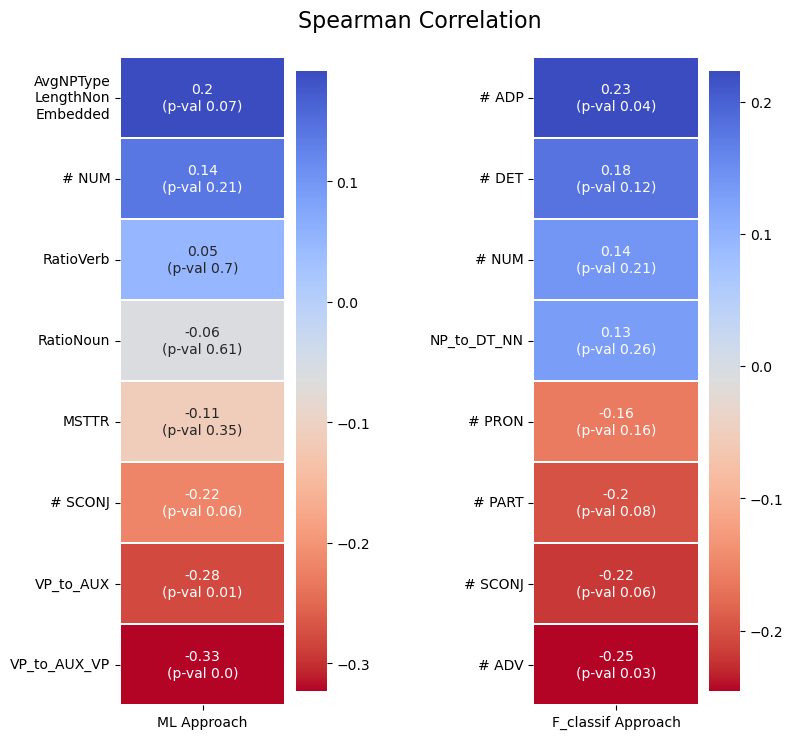

In [91]:
series, annots = get_correlation(TARGETS, spearmanr)
plot_correlation(series, annots, "Spearman Correlation")

## Shap Values

In [92]:
from sklearn.model_selection import StratifiedKFold

np.random.seed(42)
CV_REPETITIONS = 1000
N_ESTIMATORS = 200

In [93]:
# Use a dict to track the SHAP values of each observation per CV repitition
# And given that we have 2 classes, we can save the SHAP values for both classes separately
def populate_dictionaries(X, cv_repetitions):
    shap_values_per_cv_0 = dict()
    shap_values_per_cv_1 = dict()

    for sample in X.index:
        # Create keys for each sample
        shap_values_per_cv_0[sample] = {}
        shap_values_per_cv_1[sample] = {}
        # Then, keys for each CV fold within each sample
        for CV_repeat in range(cv_repetitions):
            shap_values_per_cv_0[sample][CV_repeat] = {}
            shap_values_per_cv_1[sample][CV_repeat] = {}
    return shap_values_per_cv_0, shap_values_per_cv_1

In [94]:
# Split the data into folds
def get_split(X: pd.DataFrame, y: pd.DataFrame, seed:int):
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    idx_train, idx_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X, y):
        idx_train.append(fold[0]), idx_test.append(fold[1])
    
    return idx_train, idx_test

In [95]:
def full_cv_run(X, y, idx, idx_train, idx_test, seed, shap_values_per_cv, n_estimators=200):
    # Loop through each outer fold and extract SHAP values 
    for outer_idx_train, outer_idx_test in zip(idx_train, idx_test):
        X_train, X_test = X.iloc[outer_idx_train, :], X.iloc[outer_idx_test, :]
        y_train = y.iloc[outer_idx_train]

        model = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)
        model.fit(X_train, y_train)

        # Use SHAP to explain predictions
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(outer_idx_test):
            shap_values_per_cv[0][test_index][idx] = shap_values[0][i]
            shap_values_per_cv[1][test_index][idx] = shap_values[1][i]

In [96]:
# Compute average Shap values, their Stdevs, and their min/max
def get_stats(df, shap_values_per_cv):
    average_shap_values, stds, ranges = [],[],[]
    for i in range(len(df)):
        df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
        # Get relevant statistics for every sample 
        average_shap_values.append(df_per_obs.mean(axis=1).values) 
        stds.append(df_per_obs.std(axis=1).values)
        ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

    return average_shap_values, stds, ranges

In [97]:
def explain(target, features, cv_repetitions, seeds):
    df = load_exp(features, target)
    X = df.drop(['id', target], axis=1)
    y = df[target]

    shap_values_per_cv_0, shap_values_per_cv_1 = populate_dictionaries(X, cv_repetitions)

    for idx in tqdm(range(cv_repetitions)):
        idx_train, idx_test = get_split(X, y, seeds[idx])
        full_cv_run(X, y, idx, idx_train, idx_test, seeds[idx], (shap_values_per_cv_0, shap_values_per_cv_1))

    
    average_shap_values_0, stds_0, ranges_0 = get_stats(df, shap_values_per_cv_0)
    average_shap_values_1, stds_1, ranges_1 = get_stats(df, shap_values_per_cv_1)

    return X, (average_shap_values_0, stds_0, ranges_0), (average_shap_values_1, stds_1, ranges_1)

In [98]:
def plot_shap_vals(X, average_values, label, cv_repetitions):
    shap.summary_plot(np.array(average_values), X, show = False)
    plt.title(f'Average SHAP values after {cv_repetitions}x cross-validation (class {label})')
    plt.show()

In [35]:
def plot_ranges(X, ranges: list, label: int):
    ranges = pd.DataFrame(ranges)
    ranges.columns = X.columns
    # Transpose dataframe to long form
    values, labels = [],[]
    for i in range(len(ranges.columns)):
        for j in range(len(ranges)):
            values.append(ranges.T[j][i])
            labels.append(ranges.columns[i])
    long_df = pd.DataFrame([values,labels]).T
    long_df.columns = ['Values', 'Features']


    title = f'Range of SHAP values per sample across all\ncross-validation repeats (class {label})'
    xlab, ylab = 'SHAP Value Variability', 'SHAP range per sample'
    sns.catplot(data = long_df, x = 'Features', y = 'Values').set(xlabel = xlab, ylabel = ylab,
                                                                                title = title)
    plt.xticks(rotation=45)
    plt.show()

### pTau_Positivity

In [100]:
TTAU_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp, ttau_class_0, ttau_class_1 = explain('pTau_Positivity', TTAU_EXP_FEATS_ML, CV_REPETITIONS, TTAU_SEEDS)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [15:34<00:00,  1.07it/s]


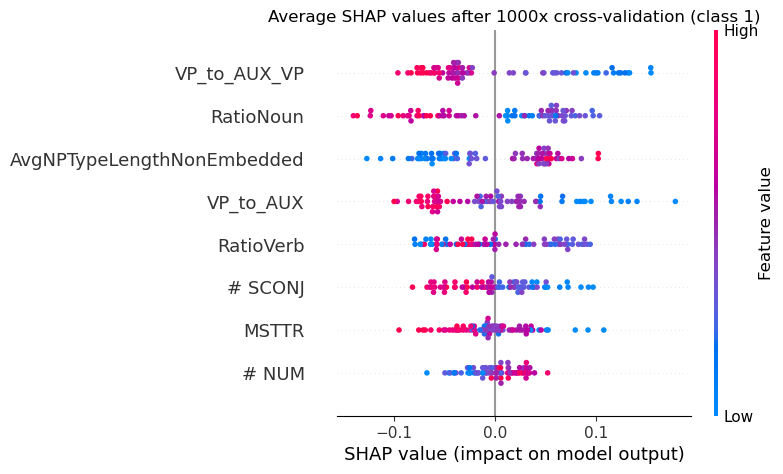

In [101]:
plot_shap_vals(X_ttau_exp, ttau_class_1[0], 1, CV_REPETITIONS)

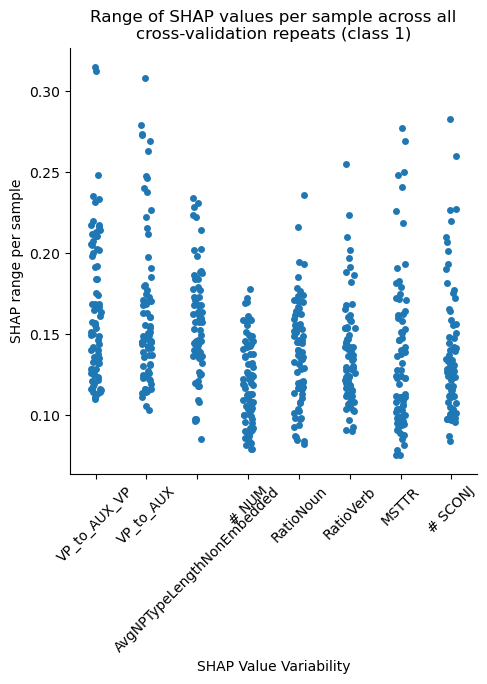

In [102]:
plot_ranges(X_ttau_exp, ttau_class_1[2], 1)

In [103]:
TTAU_SEEDS_f = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp_f, ttau_class_0_f, ttau_class_1_f = explain('pTau_Positivity', TTAU_EXP_FEATS_F_CLASS, CV_REPETITIONS, TTAU_SEEDS_f)

100%|██████████| 1000/1000 [15:47<00:00,  1.06it/s]


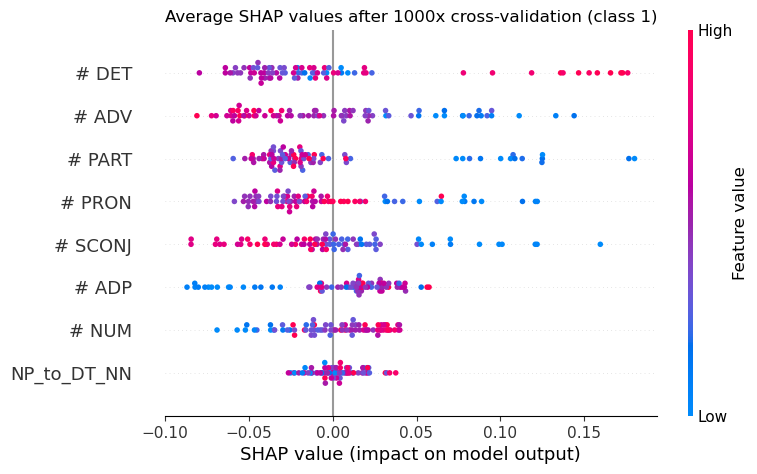

In [104]:
plot_shap_vals(X_ttau_exp_f, ttau_class_1_f[0], 1, CV_REPETITIONS)

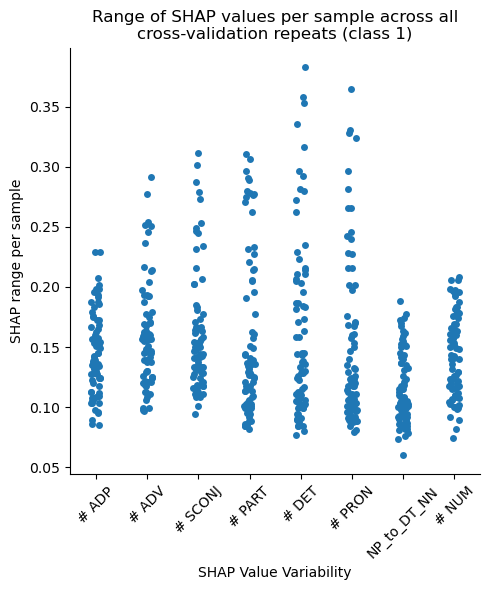

In [105]:
plot_ranges(X_ttau_exp_f, ttau_class_1_f[2], 1)